In [155]:
%pylab inline
# Pandas is a nice utilitiy that enables some easy data manipulation, especially from a csv
import pandas as pd
# Numpy lets us work with arrays
import numpy as np
# Sklearn provides various modules with a common API
from sklearn import svm, tree, neighbors, neural_network, linear_model, ensemble
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# import pickle
import pickle

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier
# import lightgbm as lgb
# from lightgbm import LGBMClassifier

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [156]:
# Read in our csv files downloaded from Kaggle
train_data = pd.read_csv('train.csv').set_index("PassengerId")
test_data = pd.read_csv('test.csv').set_index("PassengerId")

In [157]:
# We can use .head() to get just the first few rows of the data.
train_data.head()
# Note how the notebook nicely displays the output for us

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [158]:
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [159]:
train_data.columns[train_data.isna().any()].tolist()

['Age', 'Cabin', 'Embarked']

In [160]:
def parse_title(df):
    # title
    df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
    df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
    df['Title'] = df['Title'].replace('Ms','Miss')
    df['Title'] = df['Title'].replace('Mlle','Miss')
    df['Title'] = df['Title'].replace('Mme','Mrs')
    return df

def process_name(df):
    # parse title first
    df = parse_title(df)
    df['LastName'] = df.Name.str.split(',').str[0]
    # get information about sex from title
    df['IsWomanOrBoy'] = ((df.Title == 'Master') | (df.Sex == 'female'))
    # find families
    family = df.groupby(df.LastName).Survived
    # count woman or boy
#     df['WomanOrBoyCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).count())
#     df['WomanOrBoyCount'] = df.mask(df.IsWomanOrBoy, df.WomanOrBoyCount - 1, axis=0)
#     df['FamilySurvivedCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).sum())
#     df['FamilySurvivedCount'] = df.mask(df.IsWomanOrBoy, df.FamilySurvivedCount - df.Survived.fillna(0), axis=0)
#     df['WomanOrBoySurvived'] = df.FamilySurvivedCount / df.WomanOrBoyCount.replace(0, np.nan)
#     df.WomanOrBoyCount = df.WomanOrBoyCount.replace(np.nan, 0)
#     df['Alone'] = (df.WomanOrBoyCount == 0)
    return df

def fill_missing(df):
    # Embarked
    df['Embarked'] = df['Embarked'].fillna('S')
    # Cabin, Deck
    df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
    df.loc[(df['Deck'] == 'T'), 'Deck'] = 'A'

    # Thanks to https://www.kaggle.com/erinsweet/simpledetect
    # Fare
    med_fare = df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
    df['Fare'] = df['Fare'].fillna(med_fare)
    #Age
    df['Age'] = df.groupby(['Sex', 'Pclass', 'Title'])['Age'].apply(lambda x: x.fillna(x.median()))
    # Family_Size
    df['Family_Size'] = df['SibSp'] + df['Parch'] + 1
    return df    

In [161]:
def encode_types(df):
    numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    categorical_columns = []
    features = df.columns.values.tolist()
    for col in features:
        if df[col].dtype in numerics: continue
        categorical_columns.append(col)
    # Encoding categorical features
    for col in categorical_columns:
        if col in df.columns:
            le = LabelEncoder()
            le.fit(list(df[col].astype(str).values))
            df[col] = le.transform(list(df[col].astype(str).values))
    return df
    

In [162]:
RANDOM_SEED = 10

# combine train and test into single df for preprocessing --> becareful bc test won't have survived column
df = pd.concat([train_data, test_data], axis=0, sort=False)
df.head()

df = process_name(df)

# train_nan_map = {'Age': train_data['Age'].mean(), 'Fare': train_data['Fare'].mean(), 'Embarked': train_data['Embarked'].mode()[0]}
# test_nan_map = {'Age': test_data['Age'].mean(), 'Fare': test_data['Fare'].mean(), 'Embarked': test_data['Embarked'].mode()[0]}

# train_data.fillna(value=train_nan_map, inplace=True)
# test_data.fillna(value=test_nan_map, inplace=True)

# columns_map = {'Embarked': {'C': 0, 'Q': 1, 'S': 2}, 'Sex': {'male': 0, 'female': 1}}
# train_data.replace(columns_map, inplace=True)
# test_data.replace(columns_map, inplace=True)

# fill in missing
df = fill_missing(df)

# drop these columns
cols_to_drop = ['Name','Ticket','Cabin']
df = df.drop(cols_to_drop, axis=1)

# encode the string datatypes using LabelEncoder
df = encode_types(df)

# separate into data and survived label
train_data, test_data = df.loc[train_data.index], df.loc[test_data.index]
X_train = train_data.loc[:, train_data.columns != 'Survived']
y_train = train_data.loc[:, 'Survived']

# try kfold from scikit-learn
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=RANDOM_SEED)

print(X_train.head())
print(y_train.head())
print(test_data.head())

             Pclass  Sex   Age  SibSp  Parch    Fare  Embarked  Title  \
PassengerId                                                             
464               2    1  48.0      0      0  13.000         2     10   
160               3    1   6.0      8      2  69.550         2      8   
48                3    0  18.0      0      0   7.750         1      9   
403               3    0  21.0      1      0   9.825         2      9   
619               2    0   4.0      2      1  39.000         2      9   

             LastName  IsWomanOrBoy  Deck  Family_Size  
PassengerId                                             
464               524             0     7            1  
160               700             1     7           11  
48                586             1     7            1  
403               388             1     7            2  
619                66             1     5            4  
PassengerId
464    0.0
160    0.0
48     1.0
403    0.0
619    1.0
Name: Survived, dtype:

In [163]:
train_data.columns[train_data.isna().any()].tolist()
train_data[train_data['Embarked'].isna() == True]
#train_data['Embarked']
#test_data.columns[test_data.isna().any()].tolist()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,LastName,IsWomanOrBoy,Deck,Family_Size
PassengerId,,,,,,,,,,,,,


## Keeping track of models

For now we will keep a dictionary with all the models performance

Model will map to (fnr, fpr)

Next we will pickle them so we don't have to waste time retraining

In [164]:
'''
Use this method to score the cross evaluation
This way we will have the confusion matrix values for each fold and we can easily get the average fnr and fpr
'''
def confusion_matrix_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1]}

# cv_results = cross_validate(svm, X, y, cv=5,
#                             scoring=confusion_matrix_scorer)

# fit and evaluate model
y_truth = y_test.values
def eval(model):
    # cross validation --> generate different train test splits
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cnt = 1
    # split()  method generate indices to split data into training and test set.
    for train_index, test_index in kf.split(X_train.values, y_train.values):
        print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
        cnt+=1

    model.fit(X_train.values, y_train.values)

    # cross eval accuracy
    score = cross_val_score(model, X_train.values, y_train.values, cv = kf, scoring="accuracy")
    print(f'Scores for each fold are: {score}')
    print("Average Score of CVs: ", sum(score)/len(score))

    # normal accuracy
    print("Accuracy:", model.score(X_test.values, y_test.values))
    y_pred = model.predict(X_test.values)
    tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
    print("")
    print("Confusion Matrix")
    print(confusion_matrix(y_truth, y_pred, labels=[0, 1]))
    print("")
    print("True Negatives", tn)
    print("False Positives", fp)
    print("False Negatives", fn)
    print("True Positives", tp)
    print("")
    fpr = fp / (fp + tn)
    print("FPR", fpr)
    fnr = fn / (fn + tp)
    print("FNR", fnr)
    models[type(model).__name__] = (fpr, fnr)
    # print(models)

In [165]:
models = {}

## Tree

In [166]:
tree_clf = tree.DecisionTreeClassifier()
eval(tree_clf)

Fold:1, Train set: 476, Test set:120
Fold:2, Train set: 477, Test set:119
Fold:3, Train set: 477, Test set:119
Fold:4, Train set: 477, Test set:119
Fold:5, Train set: 477, Test set:119
Scores for each fold are: [0.76666667 0.74789916 0.76470588 0.76470588 0.69747899]
Average Score of CVs:  0.7482913165266106
Accuracy: 0.7830508474576271

Confusion Matrix
[[152  39]
 [ 25  79]]

True Negatives 152
False Positives 39
False Negatives 25
True Positives 79

FPR 0.20418848167539266
FNR 0.2403846153846154


## KNN

In [167]:
knn_clf = neighbors.KNeighborsClassifier()
eval(knn_clf)

Fold:1, Train set: 476, Test set:120
Fold:2, Train set: 477, Test set:119
Fold:3, Train set: 477, Test set:119
Fold:4, Train set: 477, Test set:119
Fold:5, Train set: 477, Test set:119
Scores for each fold are: [0.65       0.64705882 0.71428571 0.65546218 0.64705882]
Average Score of CVs:  0.6627731092436975
Accuracy: 0.6745762711864407

Confusion Matrix
[[155  36]
 [ 60  44]]

True Negatives 155
False Positives 36
False Negatives 60
True Positives 44

FPR 0.18848167539267016
FNR 0.5769230769230769


## NN

In [168]:
NN_clf = neural_network.MLPClassifier()
eval(NN_clf)

Fold:1, Train set: 476, Test set:120
Fold:2, Train set: 477, Test set:119
Fold:3, Train set: 477, Test set:119
Fold:4, Train set: 477, Test set:119
Fold:5, Train set: 477, Test set:119
Scores for each fold are: [0.85833333 0.74789916 0.82352941 0.68907563 0.75630252]
Average Score of CVs:  0.7750280112044818
Accuracy: 0.7830508474576271

Confusion Matrix
[[173  18]
 [ 46  58]]

True Negatives 173
False Positives 18
False Negatives 46
True Positives 58

FPR 0.09424083769633508
FNR 0.4423076923076923


## SVM

In [169]:
svm_clf = svm.SVC(kernel='linear')
eval(svm_clf)

Fold:1, Train set: 476, Test set:120
Fold:2, Train set: 477, Test set:119
Fold:3, Train set: 477, Test set:119
Fold:4, Train set: 477, Test set:119
Fold:5, Train set: 477, Test set:119
Scores for each fold are: [0.89166667 0.78991597 0.81512605 0.79831933 0.82352941]
Average Score of CVs:  0.8237114845938376
Accuracy: 0.8338983050847457

Confusion Matrix
[[168  23]
 [ 26  78]]

True Negatives 168
False Positives 23
False Negatives 26
True Positives 78

FPR 0.12041884816753927
FNR 0.25


In [170]:
svm_linear = svm.LinearSVC()
eval(svm_linear)

Fold:1, Train set: 476, Test set:120
Fold:2, Train set: 477, Test set:119
Fold:3, Train set: 477, Test set:119
Fold:4, Train set: 477, Test set:119
Fold:5, Train set: 477, Test set:119
Scores for each fold are: [0.575      0.7394958  0.66386555 0.75630252 0.59663866]
Average Score of CVs:  0.6662605042016807
Accuracy: 0.8

Confusion Matrix
[[173  18]
 [ 41  63]]

True Negatives 173
False Positives 18
False Negatives 41
True Positives 63

FPR 0.09424083769633508
FNR 0.3942307692307692


/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iteration

## Linear

In [171]:
logistic = linear_model.LogisticRegression()
eval(logistic)

Fold:1, Train set: 476, Test set:120
Fold:2, Train set: 477, Test set:119
Fold:3, Train set: 477, Test set:119
Fold:4, Train set: 477, Test set:119
Fold:5, Train set: 477, Test set:119
Scores for each fold are: [0.85833333 0.78151261 0.81512605 0.78991597 0.78151261]
Average Score of CVs:  0.8052801120448179
Accuracy: 0.8203389830508474

Confusion Matrix
[[168  23]
 [ 30  74]]

True Negatives 168
False Positives 23
False Negatives 30
True Positives 74

FPR 0.12041884816753927
FNR 0.28846153846153844


/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

In [172]:
perceptron = linear_model.Perceptron()
eval(perceptron)

Fold:1, Train set: 476, Test set:120
Fold:2, Train set: 477, Test set:119
Fold:3, Train set: 477, Test set:119
Fold:4, Train set: 477, Test set:119
Fold:5, Train set: 477, Test set:119
Scores for each fold are: [0.61666667 0.6302521  0.68907563 0.60504202 0.58823529]
Average Score of CVs:  0.6258543417366946
Accuracy: 0.6576271186440678

Confusion Matrix
[[191   0]
 [101   3]]

True Negatives 191
False Positives 0
False Negatives 101
True Positives 3

FPR 0.0
FNR 0.9711538461538461


In [173]:
ridge = linear_model.RidgeClassifier()
eval(ridge)

Fold:1, Train set: 476, Test set:120
Fold:2, Train set: 477, Test set:119
Fold:3, Train set: 477, Test set:119
Fold:4, Train set: 477, Test set:119
Fold:5, Train set: 477, Test set:119
Scores for each fold are: [0.88333333 0.78991597 0.80672269 0.80672269 0.79831933]
Average Score of CVs:  0.8170028011204481
Accuracy: 0.8406779661016949

Confusion Matrix
[[168  23]
 [ 24  80]]

True Negatives 168
False Positives 23
False Negatives 24
True Positives 80

FPR 0.12041884816753927
FNR 0.23076923076923078


In [174]:
sdg = linear_model.SGDClassifier()
eval(sdg)

Fold:1, Train set: 476, Test set:120
Fold:2, Train set: 477, Test set:119
Fold:3, Train set: 477, Test set:119
Fold:4, Train set: 477, Test set:119
Fold:5, Train set: 477, Test set:119
Scores for each fold are: [0.41666667 0.44537815 0.63865546 0.6302521  0.58823529]
Average Score of CVs:  0.5438375350140057
Accuracy: 0.6779661016949152

Confusion Matrix
[[190   1]
 [ 94  10]]

True Negatives 190
False Positives 1
False Negatives 94
True Positives 10

FPR 0.005235602094240838
FNR 0.9038461538461539


## Ensemble

In [175]:
random_forest = ensemble.RandomForestClassifier()
eval(random_forest)

Fold:1, Train set: 476, Test set:120
Fold:2, Train set: 477, Test set:119
Fold:3, Train set: 477, Test set:119
Fold:4, Train set: 477, Test set:119
Fold:5, Train set: 477, Test set:119
Scores for each fold are: [0.86666667 0.79831933 0.79831933 0.84033613 0.81512605]
Average Score of CVs:  0.8237535014005604
Accuracy: 0.8135593220338984

Confusion Matrix
[[163  28]
 [ 27  77]]

True Negatives 163
False Positives 28
False Negatives 27
True Positives 77

FPR 0.14659685863874344
FNR 0.25961538461538464


In [176]:
gradient_boost = ensemble.GradientBoostingClassifier()
eval(gradient_boost)

Fold:1, Train set: 476, Test set:120
Fold:2, Train set: 477, Test set:119
Fold:3, Train set: 477, Test set:119
Fold:4, Train set: 477, Test set:119
Fold:5, Train set: 477, Test set:119
Scores for each fold are: [0.86666667 0.81512605 0.8487395  0.84033613 0.79831933]
Average Score of CVs:  0.8338375350140057
Accuracy: 0.8338983050847457

Confusion Matrix
[[165  26]
 [ 23  81]]

True Negatives 165
False Positives 26
False Negatives 23
True Positives 81

FPR 0.13612565445026178
FNR 0.22115384615384615


In [177]:
extra_trees = ensemble.ExtraTreesClassifier()
eval(extra_trees)

Fold:1, Train set: 476, Test set:120
Fold:2, Train set: 477, Test set:119
Fold:3, Train set: 477, Test set:119
Fold:4, Train set: 477, Test set:119
Fold:5, Train set: 477, Test set:119
Scores for each fold are: [0.875      0.78151261 0.78991597 0.82352941 0.76470588]
Average Score of CVs:  0.8069327731092436
Accuracy: 0.823728813559322

Confusion Matrix
[[164  27]
 [ 25  79]]

True Negatives 164
False Positives 27
False Negatives 25
True Positives 79

FPR 0.14136125654450263
FNR 0.2403846153846154


In [178]:
bagging = ensemble.BaggingClassifier()
eval(bagging)

Fold:1, Train set: 476, Test set:120
Fold:2, Train set: 477, Test set:119
Fold:3, Train set: 477, Test set:119
Fold:4, Train set: 477, Test set:119
Fold:5, Train set: 477, Test set:119
Scores for each fold are: [0.84166667 0.76470588 0.78991597 0.79831933 0.79831933]
Average Score of CVs:  0.7985854341736693
Accuracy: 0.8271186440677966

Confusion Matrix
[[165  26]
 [ 25  79]]

True Negatives 165
False Positives 26
False Negatives 25
True Positives 79

FPR 0.13612565445026178
FNR 0.2403846153846154


In [179]:
# voting = ensemble.VotingClassifier(estimators=20)
# eval(voting)

In [180]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def show_matrix(model):
    y_pred = model.predict(X_test)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_truth, y_pred)
    class_names=['0', '1']
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                        title='Confusion matrix, without normalization')

    plt.show()

show_matrix(knn_clf)

In [228]:
def create_pred_csv(model):
    predictions = model.predict(test_data.values)
    pred_df = pd.DataFrame(predictions, index=test_data.index, columns=['Survived'])
    type(pred_df)
    pred_df.to_csv(str(model.__name__) + 'predictions.csv', header=True, sep=',')


# think the test_data has NaN so it really doesn't like it
create_pred_csv(knn_clf)

## Function to display pareto front

We will give it the model dict and all the fpr and fnr that we have

https://oapackage.readthedocs.io/en/latest/examples/example_pareto.html

https://stackoverflow.com/questions/21294829/fast-calculations-of-the-pareto-front-in-r

The trick here is to sort by x, which then allows you to limit your check to making sure that all prior values of x must have greater values of y to ensure that point is on the frontier.

In [222]:
def create_models_df(models):
    df = pd.DataFrame(columns = ['model', 'fpr', 'fnr'])
    for model in models:
        fpr, fnr = models[model]
        df.loc[len(df.index)] = [model, fpr, fnr]
    return df

def find_hof(df):
    out = {}
    for index, row in df.iterrows():
        # look at all the models with a higher fpr
        tmp = df[df.fpr < row['fpr']]
        # drop the ones with a higher fnr
        tmp = tmp[tmp.fnr <= row['fnr']]
        # not optimal
        if tmp.size == 0:
            model = row['model']
            fpr = row['fpr']
            fnr = row['fnr']
            out[model] = (fpr, fnr)
    return out


df = create_models_df(models)
hof = find_hof(df)
print(hof)


{'MLPClassifier': (0.09424083769633508, 0.4423076923076923), 'SVC': (0.12041884816753927, 0.25), 'LinearSVC': (0.09424083769633508, 0.3942307692307692), 'LogisticRegression': (0.12041884816753927, 0.28846153846153844), 'Perceptron': (0.0, 0.9711538461538461), 'RidgeClassifier': (0.12041884816753927, 0.23076923076923078), 'SGDClassifier': (0.005235602094240838, 0.9038461538461539), 'GradientBoostingClassifier': (0.13612565445026178, 0.22115384615384615)}


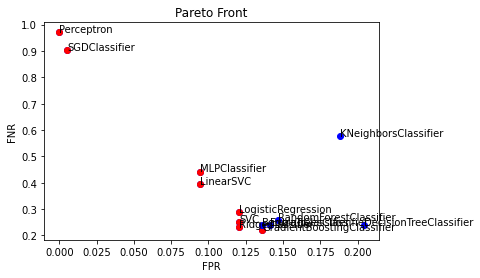

In [226]:
def pareto_frontier(models, hof):
    for model in models:
        fpr, fnr = models[model]
        plt.scatter(fpr, fnr, color='b')
        if model in hof:
            best_fpr, best_fnr = hof[model]
            plt.scatter(best_fpr, best_fnr, color='r')
            plt.plot(best_fpr, best_fnr, color='r', drawstyle='steps-post')

        plt.annotate(str(model), (fpr, fnr))
    plt.xlabel("FPR")
    plt.ylabel("FNR")
    plt.title("Pareto Front")
    plt.show()
pareto_frontier(models, hof)